In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,'/home/bradhakrishnan/ECE276A_PR1/code/')

In [3]:
import motion_calibration
import load_data
import jax
import jax.numpy as jnp
import quaternion_ops as qops 

dataset_idx= 1
jax.config.update("jax_enable_x64", True)


In [5]:
calibrated_imu, vicd_data, camera_data= motion_calibration.calibrate_v2(dataset_idx,400)

Dataset 1 :: 

Data import took: 6.0446906089782715 sec.

Dataset 1 :: 

Data import took: 3.442704200744629 sec.

[-510.82793017 -500.9925187   605.16209476  373.56857855  375.34164589
  369.67082294]


In [63]:
import transforms3d as t3d

def motion_model_rollover(calibrated_imu):
    pred_qts= [jnp.array([1,0,0,0])]
    exp_vals=[]
    for idx in range(0,calibrated_imu.shape[1]-1):
        exp_term= calibrated_imu[4:,idx]* (calibrated_imu[0,idx+1]- calibrated_imu[0,idx])/2
        exp_val= t3d.quaternions.qexp(jnp.concatenate((jnp.array([0]),exp_term)))
        exp_vals.append(exp_val)
        pred_qts.append(t3d.quaternions.qmult(pred_qts[idx],exp_val))
    pred_qts= jnp.column_stack(pred_qts)
    exp_vals=jnp.column_stack(exp_vals)
    return pred_qts, exp_vals

In [64]:
qts,exp_vals= motion_model_rollover(calibrated_imu)
linear_acc= jnp.vstack((jnp.zeros(calibrated_imu.shape[1]), calibrated_imu[1:4,:]))

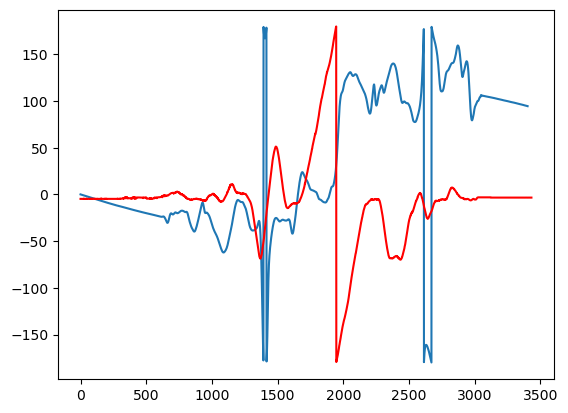

In [65]:
pred_roll=[0]* calibrated_imu.shape[-1]
pred_pitch=[0]*  calibrated_imu.shape[-1] 
pred_yaw =[0]* calibrated_imu.shape[-1]

gt_roll=[0]* vicd_data['rots'].shape[-1]
gt_pitch=[0]*  vicd_data['rots'].shape[-1] 
gt_yaw =[0]* vicd_data['rots'].shape[-1]


for idx in range(0,calibrated_imu.shape[-1]):    
    pred_roll[idx], pred_pitch[idx], pred_yaw[idx] = jnp.array(
t3d.euler.quat2euler(qts[:, idx], 'sxyz')
) * (180 / jnp.pi)
for idx in range(0,vicd_data['rots'].shape[-1]): 
    gt_roll[idx], gt_pitch[idx], gt_yaw[idx] = jnp.array(
t3d.euler.mat2euler(vicd_data['rots'][:,:, idx], 'sxyz')
) * (180 / jnp.pi)

plt.plot(pred_yaw)
plt.plot(gt_yaw,color='red')

In [7]:
def obs_model(q):
    return qops.qmult(qops.qinverse(q),qops.qmult(jnp.array([0., 0., 0., 1]),q))

def motion_model(q,exp):
    return qops.qmult(q, exp)

def rotation_err(qt_1, ft):
    return jnp.linalg.norm(2*qops.qlog(qops.qmult(qops.qinverse(qt_1), ft))) **2

def position_err(at, ht):
    return jnp.linalg.norm(at-ht) **2

hts= jax.vmap(obs_model, in_axes=(1), out_axes=1)
fts= jax.vmap(motion_model, in_axes=(1,1), out_axes=1)

rot_error_vec=jax.vmap(rotation_err, in_axes=(1,1))
pos_error_vec= jax.vmap(position_err, in_axes=(1,1))


In [8]:
def vector_normalize(q):
    return q/ jnp.linalg.norm(q)
    
def cost_fn(QTS, linear_acc, exp_vals):
    return (pos_error_vec(linear_acc[:,1:], hts(QTS[:,1:])).sum()+rot_error_vec(QTS[:,1:],fts(QTS[:,:-1], exp_vals)).sum())/2

In [9]:
from tqdm import tqdm
norm_vec= jax.vmap(vector_normalize, in_axes=(1),out_axes=1)
grads=[]

pred_qts= qts
step_size= 0.001
epochs=400
epsilon= 1e-6
for epoch in tqdm(range(epochs)):
    cost=cost_fn(pred_qts,linear_acc,exp_vals)
    grad= jax.jacrev(cost_fn)(pred_qts,linear_acc,exp_vals)
    grad=jnp.where(jnp.isnan(grad), epsilon, grad)
    pred_qts=norm_vec(pred_qts- (grad*step_size))
    pred_qts=pred_qts.at[:,0].set(jnp.array([1.,0.,0.,0.]))
    grads.append(cost)
    

100%|██████████| 400/400 [01:51<00:00,  3.58it/s]


In [14]:
import os
import runner
data_base_path= "/home/bradhakrishnan/ECE276A_PR1/data/"
save_folder=os.path.join(data_base_path, "outputs", str(dataset_idx))
runner.plot_and_save_euler_angles(pred_qts, vicd_data, save_folder)

Plots saved to /home/bradhakrishnan/ECE276A_PR1/data/outputs/2


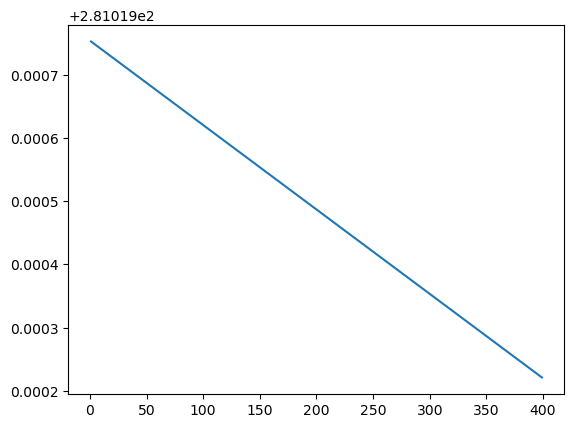

In [15]:
import matplotlib.pyplot as plt

plt.plot(grads)

In [60]:
grads

[Array(nan, dtype=float64),
 Array(281.01975269, dtype=float64),
 Array(281.01975135, dtype=float64),
 Array(281.01975002, dtype=float64),
 Array(281.01974868, dtype=float64),
 Array(281.01974735, dtype=float64),
 Array(281.01974601, dtype=float64),
 Array(281.01974467, dtype=float64),
 Array(281.01974334, dtype=float64),
 Array(281.019742, dtype=float64),
 Array(281.01974067, dtype=float64),
 Array(281.01973933, dtype=float64),
 Array(281.019738, dtype=float64),
 Array(281.01973666, dtype=float64),
 Array(281.01973532, dtype=float64),
 Array(281.01973399, dtype=float64),
 Array(281.01973265, dtype=float64),
 Array(281.01973132, dtype=float64),
 Array(281.01972998, dtype=float64),
 Array(281.01972864, dtype=float64),
 Array(281.01972731, dtype=float64),
 Array(281.01972597, dtype=float64),
 Array(281.01972464, dtype=float64),
 Array(281.0197233, dtype=float64),
 Array(281.01972197, dtype=float64),
 Array(281.01972063, dtype=float64),
 Array(281.01971929, dtype=float64),
 Array(281.0197

In [61]:
pred_roll=[0]* calibrated_imu.shape[-1]
pred_pitch=[0]*  calibrated_imu.shape[-1] 
pred_yaw =[0]* calibrated_imu.shape[-1]

gt_roll=[0]* vicd_data['rots'].shape[-1]
gt_pitch=[0]*  vicd_data['rots'].shape[-1] 
gt_yaw =[0]* vicd_data['rots'].shape[-1]


for idx in range(0,calibrated_imu.shape[-1]):    
    pred_roll[idx], pred_pitch[idx], pred_yaw[idx] = jnp.array(
t3d.euler.quat2euler(pred_qts[:, idx], 'sxyz')
) * (180 / jnp.pi)
for idx in range(0,vicd_data['rots'].shape[-1]): 
    gt_roll[idx], gt_pitch[idx], gt_yaw[idx] = jnp.array(
t3d.euler.mat2euler(vicd_data['rots'][:,:, idx], 'sxyz')
) * (180 / jnp.pi)

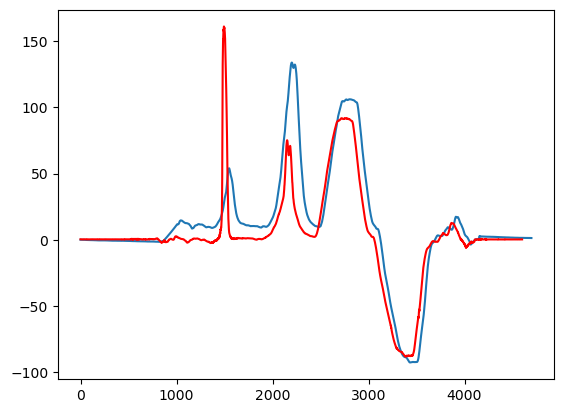

In [62]:
plt.plot(pred_roll)
plt.plot(gt_roll,color='red')

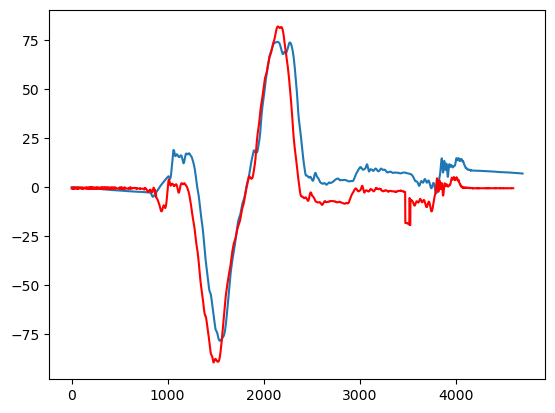

In [63]:
plt.plot(pred_pitch)
plt.plot(gt_pitch,color='red')

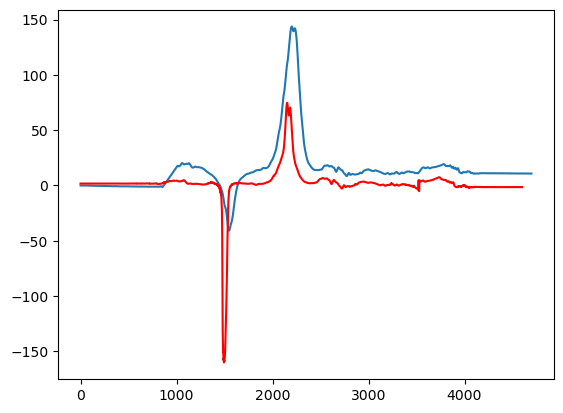

In [64]:
plt.plot(pred_yaw)
plt.plot(gt_yaw,color='red')

In [65]:
qops.qlog(jnp.array([1,0,0,0]))

Array([ 0., nan, nan, nan], dtype=float64)

In [5]:
from runner import run
for ii in range(11,12):
    run(ii, epochs=500)


Dataset 11 :: 

Data import took: 0.2197425365447998 sec.

Dataset 11 :: 

Data import took: 0.20590496063232422 sec.

[-510.73815461 -501.04488778  605.92269327  373.6159601   375.36907731
  369.57605985]


100%|██████████| 500/500 [02:16<00:00,  3.66it/s]


Plot saved to /home/bradhakrishnan/ECE276A_PR1/data/outputs/11/euler_angles_subplots.png
Plot saved to /home/bradhakrishnan/ECE276A_PR1/data/outputs/11/acc_subplots.png


In [ ]:
pred_qts= jnp.column_stack(pred_qts)


In [9]:
import transforms3d as t3d

N_gt = vicd_data['rots'].shape[-1]




In [13]:

vicd_qts= []
for idx in range(N_gt):
    vicd_qts.append( jnp.array(
        t3d.quaternions.mat2quat(vicd_data['rots'][:, :, idx])))
vicd_qts= jnp.column_stack(vicd_qts)
acc_vicd= runner.hts(vicd_qts)
acc_pred= runner.hts(pred_qts)

In [14]:
acc_vicd.shape

(4, 5561)

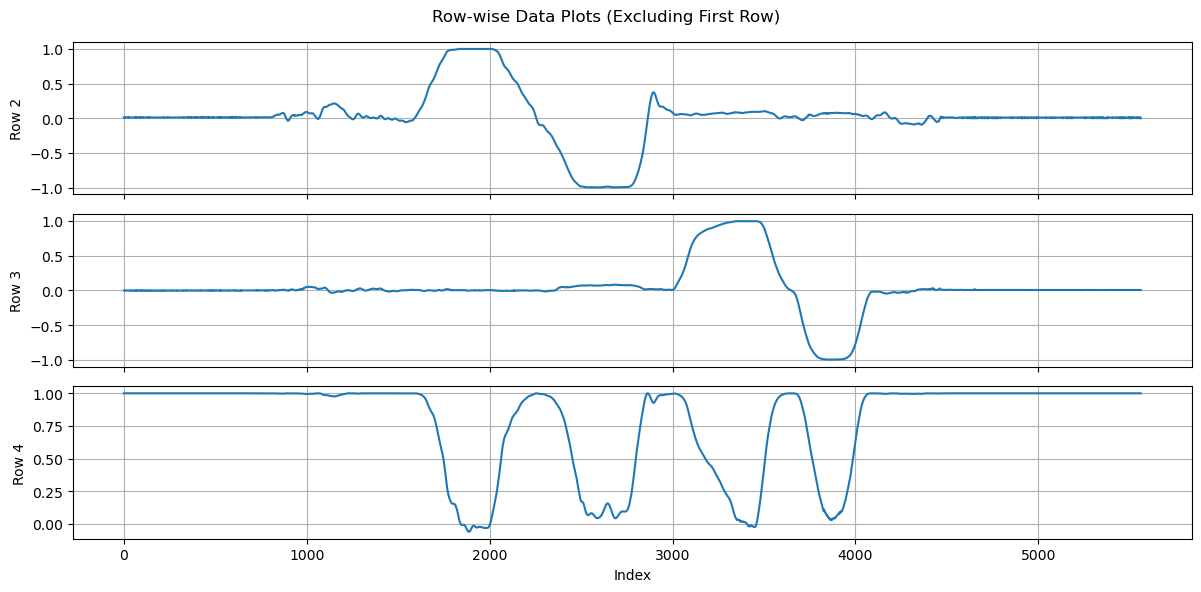

In [17]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Example JAX array of shape (4, 5561)
data = acc_vicd  # Replace with your actual data
data2= acc_pred
# Create 3 separate subplots (excluding the first row)
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

for i in range(1, 4):  # Start from row index 1
    axes[i-1].plot(data[i])
    axes[i-1].set_ylabel(f'Row {i+1}')
    axes[i-1].grid(True)

axes[-1].set_xlabel('Index')
plt.suptitle('Row-wise Data Plots (Excluding First Row)')
plt.tight_layout()
plt.show()
